In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:
zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm,num_eigen=11,init_vector=None,num_Lanczos=None,iteration=None,tolerance=0)

In [6]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM02/spencer/daily_filt/filtered_vels.zarr')


#eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1/filtered_eta_nom.zarr')
#eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
steric2 = xr.open_zarr('/swot/SUM02/spencer/steric_inc_mean.zarr')
steric_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_mean.zarr')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

eta_eul = steric2.steric-steric_mean.steric + eta_mean.Eta

frontogenesis=xr.open_zarr('/swot/SUM02/spencer/daily_filt/frontogenesis_subset.zarr')

uvel_filtered = vels_filtered.u.isel(time=slice(1,110))
vvel_filtered = vels_filtered.v.isel(time=slice(1,110))
#ssh_filtered = eta_filtered.eta.isel(time=slice(1,110))

#uvel_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
#vvel_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
#ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))


#uvel_filtered = uvel_filtered.drop_vars('time')
#vvel_filtered = vvel_filtered.drop_vars('time')
#uvel_unfiltered = uvel_unfiltered.drop_vars('time')
#vvel_unfiltered = vvel_unfiltered.drop_vars('time')
grid = Grid(uvel_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 32
  **blockwise_kwargs,


In [7]:
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)

In [8]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=1709
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

u_eul_unfilt = uvel_eul.U.isel(time=slice(1,1800))
v_eul_unfilt = vvel_eul.V.isel(time=slice(1,1800))

u_eul_filtered = u_eul_filtered.isel(time=slice(1,1700,24)).drop_vars('time')
v_eul_filtered = v_eul_filtered.isel(time=slice(1,1700,24)).drop_vars('time')

In [9]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
uvel_filtered = uvel_filtered.swap_dims({"i": "x0"})
uvel_filtered = uvel_filtered.swap_dims({"j": "y0"})
vvel_filtered = vvel_filtered.swap_dims({"i": "x0"})
vvel_filtered = vvel_filtered.swap_dims({"j": "y0"})
uvel_unfiltered = u_eul_unfilt.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
uvel_unfiltered = uvel_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
vvel_unfiltered = v_eul_unfilt.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
vvel_unfiltered = vvel_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

#ssh_filtered = ssh_filtered.swap_dims({"i": "x0"})
#ssh_filtered = ssh_filtered.swap_dims({"j": "y0"})
ssh_unfiltered = eta_eul.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
ssh_unfiltered = ssh_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
ssh_unfiltered = ssh_unfiltered.isel(time=slice(43,43+nofiles))
ssh_unfiltered = ssh_unfiltered.isel(time=slice(1,1700,24)).drop_vars('time')

frontogenesis = frontogenesis.frontogenesis.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
frontogenesis = frontogenesis.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

In [49]:
xmin=900#region b: -200#region c:+500
xmax=-900#region b: -200#region c:+500

ymin=900#region b:+750#region c: +250
ymax=-900#region b:+750#region c: +250
lons, lats = np.meshgrid(uvel_filtered.x0.isel(x0=slice(xmin,xmax)).values, uvel_filtered.y0.isel(y0=slice(ymin,ymax)).values)

In [50]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =center_point.x0.values.item(),-center_point.y0.values.item()#region b:3,32 # region c: 17,40
    #region a: center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 0, 1))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

In [51]:
x_resampled = ufunc_resample((u_eul_filtered.x0.isel(x0=slice(xmin,xmax))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).isel(time=slice(0,10)))).load().T)
y_resampled = ufunc_resample((u_eul_filtered.y0.isel(y0=slice(ymin,ymax))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).isel(time=slice(0,10)))).load().T)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [16]:
x_resampled.min()

<xarray.DataArray ()>
array(13.72770019)
Coordinates:
    k        int64 0

In [28]:
x_resampled.max()

<xarray.DataArray ()>
array(10.48294415)
Coordinates:
    k        int64 0

In [29]:
y_resampled.min()

<xarray.DataArray ()>
array(-45.94541821)
Coordinates:
    k        int64 0

In [30]:
y_resampled.max()

<xarray.DataArray ()>
array(-41.04812504)
Coordinates:
    k        int64 0

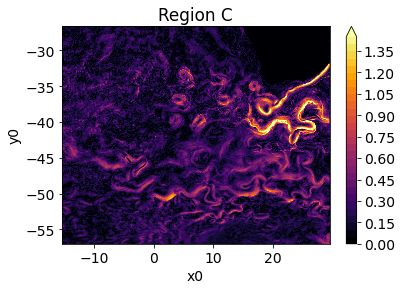

In [24]:
import matplotlib.patches as patches

speed = (uvel_unfiltered**2+vvel_unfiltered**2)**0.5
speed.isel(time=1).plot.pcolormesh(rasterized=True,levels=np.arange(0,1.5,0.05),cmap='inferno')

# Create a Rectangle patch
rect = patches.Rectangle((x_resampled.min().values, y_resampled.min().values), x_resampled.max().values
                         -x_resampled.min().values, y_resampled.max().values
                         -y_resampled.min().values, linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.title('Region C')
fig=plt.gcf()
fig.savefig('region_c.png')

In [52]:
u_eul_resampled = ufunc_resample(u_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
v_eul_resampled = ufunc_resample(v_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
u_resampled = ufunc_resample(uvel_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
v_resampled = ufunc_resample(vvel_filtered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [14]:
fronto_resampled = ufunc_resample(frontogenesis.squeeze().isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [79]:
ssh_unfiltered

<xarray.DataArray (time: 71, y0: 2160, x0: 2160)>
dask.array<getitem, shape=(71, 2160, 2160), dtype=float32, chunksize=(1, 270, 540), chunktype=numpy.ndarray>
Coordinates:
    face     int64 1
    i        (x0) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    j        (y0) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
    niter    (time) int64 16704 20160 23616 27072 ... 251712 255168 258624
    x        (y0, x0) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    y        (y0, x0) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
  * x0       (x0) float64 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49
  * y0       (y0) float64 -57.0 -56.99 -56.98 -56.97 ... -26.69 -26.68 -26.66
Dimensions without coordinates: time

In [53]:
u_resampled_unfilt = ufunc_resample(uvel_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
v_resampled_unfilt = ufunc_resample(vvel_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(ymin,ymax)).load())
eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [54]:
u_eul_resampled = u_eul_resampled.assign_coords(x1=("x1", u_eul_resampled.x1.values)).assign_coords(y1=("y1", u_eul_resampled.y1.values))
v_eul_resampled = v_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
#eta_eul_resampled = eta_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
#eta_resampled = eta_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
u_resampled_unfilt = u_resampled_unfilt.assign_coords(x1=("x1", u_resampled_unfilt.x1.values)).assign_coords(y1=("y1", u_resampled_unfilt.y1.values))
v_resampled_unfilt = v_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))
eta_resampled_unfilt = eta_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))

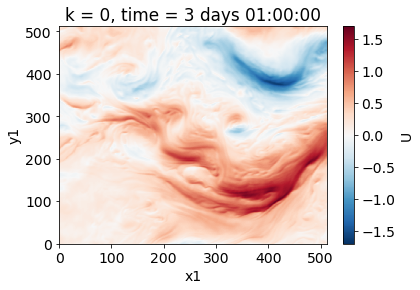

In [47]:
u_resampled_unfilt.isel(time=1).plot()

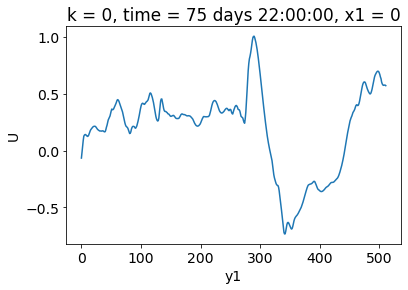

In [48]:
u_resampled_unfilt.isel(time=-1,x1=0).plot()

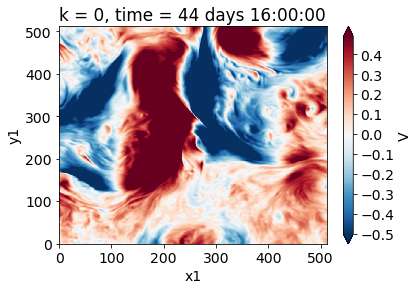

In [49]:
v_resampled_unfilt.isel(time=1000).plot(levels=np.arange(-0.5,0.5,0.01))

In [55]:
#for torres filter, we should actually compute the fourier transform first
with ProgressBar():
    u2_xs_unfilt = xrft.dft(u_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()#,window=True,window_correction=True
    v2_xs_unfilt = xrft.dft(v_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()#,window=True
    #u2_xs_unfilt_nowin = xrft.dft(u_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()#,window=True,window_correction=True
    #v2_xs_unfilt_nowin = xrft.dft(v_resampled_unfilt.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
kx = v2_xs_unfilt.freq_x1
ky = v2_xs_unfilt.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600
u2_xs_tofilt = u2_xs_unfilt.where(np.abs(u2_xs_unfilt.freq_time)*xr.ones_like(u2_xs_unfilt)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilt = v2_xs_unfilt.where(np.abs(v2_xs_unfilt.freq_time)*xr.ones_like(v2_xs_unfilt)<omegaM[:,:,10]/np.pi/2)
windows,_ = xrft.xrft._apply_window(u_resampled_unfilt.drop_vars('time'), dims=['x1','y1','time'],window_type='tukey')
vel_ps_eul_torres = (np.abs(u2_xs_tofilt)**2 + np.abs(v2_xs_tofilt)**2)*0.5/(windows**2).mean()/5825.42222222

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [56]:
with ProgressBar():
    u2_xs_wnfilt = xrft.idft(u2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
    v2_xs_wnfilt = xrft.idft(v2_xs_tofilt.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:506: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.idft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider using xrft.ifft to ensure future compatibility with numpy.ifft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [57]:
u_wnfilt = (u2_xs_wnfilt/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#
v_wnfilt = (v2_xs_wnfilt/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#

u_unfilt = u_resampled_unfilt.isel(time=slice(43,1700,24))
v_unfilt = v_resampled_unfilt.isel(time=slice(43,1700,24))

In [20]:
#eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())

In [58]:
tangrid = Grid(eta_resampled_unfilt, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

In [59]:
f = 2*2*np.pi/24/3600*np.sin(y_resampled.isel(time=0)*np.pi/180)
g=9.81
tangrid.diff(eta_resampled_unfilt,'X')
u_g = (-g/f*tangrid.interp(tangrid.diff(eta_resampled_unfilt,'Y'),'Y'))/1000
v_g = (g/f*tangrid.interp(tangrid.diff(eta_resampled_unfilt,'X'),'X'))/1000

In [60]:
last_time = 70
geostrophic_speed = (u_g.isel(time=slice(0,last_time))**2 
                    + v_g.isel(time=slice(0,last_time))**2)**0.5
wnfiltered_speed = (u_wnfilt.isel(time=slice(0,last_time))**2 
                    + v_wnfilt.isel(time=slice(0,last_time))**2)**0.5
filtered_speed = (u_resampled.isel(time=slice(0,last_time))**2 
                    + v_resampled.isel(time=slice(0,last_time))**2)**0.5
eulfiltered_speed = (u_eul_resampled.isel(time=slice(0,last_time))**2 
                    + v_eul_resampled.isel(time=slice(0,last_time))**2)**0.5
unfiltered_speed = (u_unfilt.isel(time=slice(0,last_time))**2 
                    + v_unfilt.isel(time=slice(0,last_time))**2)**0.5

In [61]:
rms_wnfiltered = ((((wnfiltered_speed.drop_vars(['x1','y1']).isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()

rms_filtered = ((((filtered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()
rms_eulfiltered = ((((eulfiltered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()
rms_unfiltered = ((((unfiltered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()


In [48]:
#rms_unfiltered_b = rms_unfiltered
#rms_eulfiltered_b = rms_eulfiltered
#rms_filtered_b = rms_filtered
#rms_wnfiltered_b = rms_wnfiltered

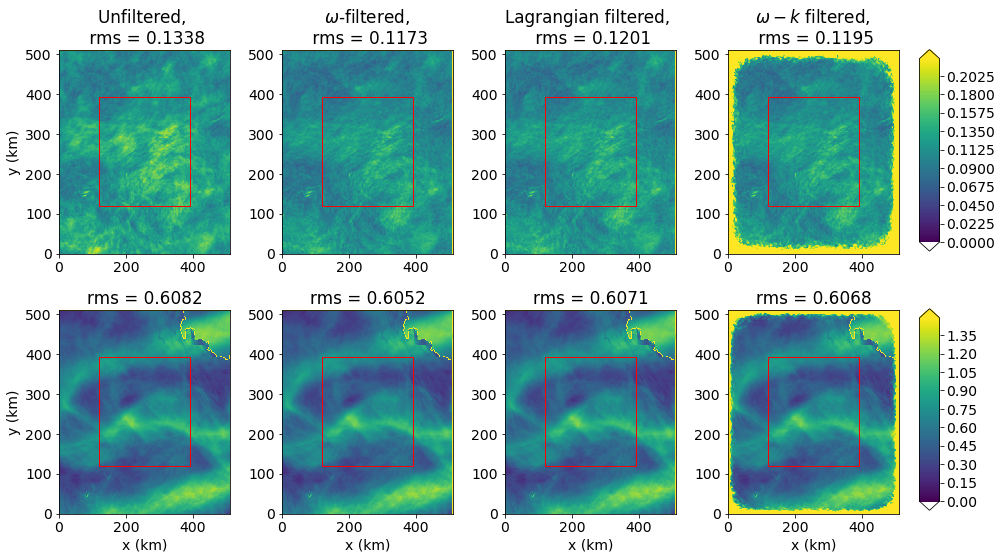

In [80]:
import matplotlib.patches as patches
rms_wnfiltered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean()

fig=plt.figure(figsize=(14,8))
plt.subplot(241)

rms_unfiltered.plot(levels=np.arange(0,1.5,0.01)*0.15,add_colorbar=False)
plt.title('Unfiltered, \n rms = %1.4f'%rms_unfiltered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
# Create a Rectangle patch
rect = patches.Rectangle((rms_unfiltered.x1.isel(x1=120), rms_unfiltered.y1.isel(y1=120)), rms_unfiltered.x1.isel(x1=-120)-rms_unfiltered.x1.isel(x1=120),
                         rms_unfiltered.y1.isel(y1=-120)-rms_unfiltered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)
plt.ylabel('y (km)')
plt.xlabel('')


plt.subplot(242)
rms_eulfiltered.plot(levels=np.arange(0,1.5,0.01)*0.15,add_colorbar=False)
plt.title('$\omega$-filtered, \n rms = %1.4f'%rms_eulfiltered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
# Create a Rectangle patch
rect = patches.Rectangle((rms_eulfiltered.x1.isel(x1=120), rms_eulfiltered.y1.isel(y1=120)), rms_eulfiltered.x1.isel(x1=-120)-rms_eulfiltered.x1.isel(x1=120),
                         rms_eulfiltered.y1.isel(y1=-120)-rms_eulfiltered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)
plt.xlabel('')
plt.ylabel('')


plt.subplot(243)
rms_filtered.plot(levels=np.arange(0,1.5,0.01)*0.15,add_colorbar=False)
plt.title('Lagrangian filtered, \n rms = %1.4f'%rms_filtered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
plt.ylabel('')

rect = patches.Rectangle((rms_filtered.x1.isel(x1=120), rms_filtered.y1.isel(y1=120)), rms_filtered.x1.isel(x1=-120)-rms_filtered.x1.isel(x1=120),
                         rms_filtered.y1.isel(y1=-120)-rms_filtered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.xlabel('')
plt.ylabel('')

plt.subplot(244)
cs = rms_wnfiltered.plot(levels=np.arange(0,1.5,0.01)*0.15,add_colorbar=False)
plt.title('$\omega-k$ filtered, \n rms = %1.4f'%rms_wnfiltered.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
plt.ylabel('')


rect = patches.Rectangle((rms_wnfiltered.x1.isel(x1=120), rms_wnfiltered.y1.isel(y1=120)), rms_wnfiltered.x1.isel(x1=-120)-rms_wnfiltered.x1.isel(x1=120),
                         rms_wnfiltered.y1.isel(y1=-120)-rms_wnfiltered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.xlabel('')
plt.ylabel('')

plt.subplot(245)

rms_unfiltered_b.plot(levels=np.arange(0,1.5,0.01),add_colorbar=False)
plt.title('rms = %1.4f'%rms_unfiltered_b.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
# Create a Rectangle patch
rect = patches.Rectangle((rms_unfiltered.x1.isel(x1=120), rms_unfiltered.y1.isel(y1=120)), rms_unfiltered.x1.isel(x1=-120)-rms_unfiltered.x1.isel(x1=120),
                         rms_unfiltered.y1.isel(y1=-120)-rms_unfiltered.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)
plt.ylabel('y (km)')
plt.xlabel('x (km)')


plt.subplot(246)
rms_eulfiltered_b.plot(levels=np.arange(0,1.5,0.01),add_colorbar=False)
plt.title('rms = %1.4f'%rms_eulfiltered_b.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
# Create a Rectangle patch
rect = patches.Rectangle((rms_eulfiltered_b.x1.isel(x1=120), rms_eulfiltered_b.y1.isel(y1=120)), rms_eulfiltered_b.x1.isel(x1=-120)-rms_eulfiltered_b.x1.isel(x1=120),
                         rms_eulfiltered_b.y1.isel(y1=-120)-rms_eulfiltered_b.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)
plt.xlabel('x (km)')
plt.ylabel('')


plt.subplot(247)
rms_filtered_b.plot(levels=np.arange(0,1.5,0.01),add_colorbar=False)
plt.title('rms = %1.4f'%rms_filtered_b.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
plt.ylabel('')

rect = patches.Rectangle((rms_filtered_b.x1.isel(x1=120), rms_filtered_b.y1.isel(y1=120)), rms_filtered_b.x1.isel(x1=-120)-rms_filtered_b.x1.isel(x1=120),
                         rms_filtered_b.y1.isel(y1=-120)-rms_filtered_b.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.xlabel('x (km)')
plt.ylabel('')

plt.subplot(248)
cs2 = rms_wnfiltered_b.plot(levels=np.arange(0,1.5,0.01),add_colorbar=False)
plt.title('rms = %1.4f'%rms_wnfiltered_b.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item())
plt.ylabel('')


rect = patches.Rectangle((rms_wnfiltered_b.x1.isel(x1=120), rms_wnfiltered_b.y1.isel(y1=120)), rms_wnfiltered_b.x1.isel(x1=-120)-rms_wnfiltered_b.x1.isel(x1=120),
                         rms_wnfiltered_b.y1.isel(y1=-120)-rms_wnfiltered_b.y1.isel(y1=120), linewidth=1, edgecolor='r', facecolor='none')

ax=plt.gca()
ax.add_patch(rect)

plt.xlabel('x (km)')
plt.ylabel('')


plt.tight_layout()

cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.35])
fig.colorbar(cs, cax=cbar_ax,extend='both')

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.35])
fig.colorbar(cs2, cax=cbar_ax,extend='both')

fig=plt.gcf()
fig.savefig('rms_region_b.png')

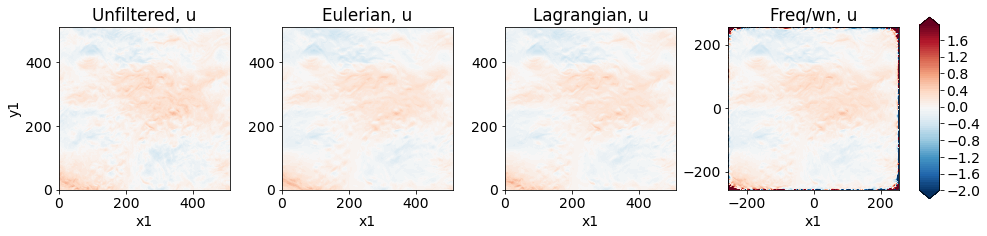

In [53]:
fig=plt.figure(figsize=(14,3.5))

tt=35
plt.subplot(141)
u_unfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.title('Unfiltered, u')

plt.subplot(142)
u_eul_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.ylabel('')
plt.title('Eulerian, u')

plt.subplot(143)
u_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.ylabel('')
plt.title('Lagrangian, u')

plt.subplot(144)
cs = u_wnfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.ylabel('')
plt.title('Freq/wn, u')

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
#fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)

In [415]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4

for tt in range(0,70):
    fig=plt.figure(figsize=(14,3.5))

    plt.subplot(141)
    u_unfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.title('Unfiltered, u')

    plt.subplot(142)
    u_eul_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Eulerian, u')

    plt.subplot(143)
    u_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Lagrangian, u')

    plt.subplot(144)
    cs = u_wnfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Freq/wn, u')

    plt.tight_layout()

    fig.subplots_adjust(right=0.9,wspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
    fig.colorbar(cs, cax=cbar_ax,extend='both')
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)
    plt.close(fig) 

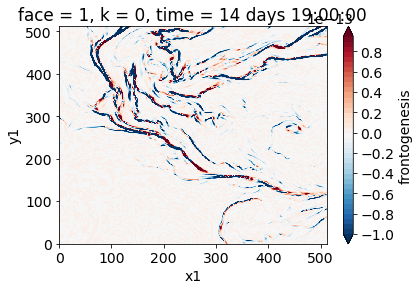

In [133]:
fronto_resampled.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-13)

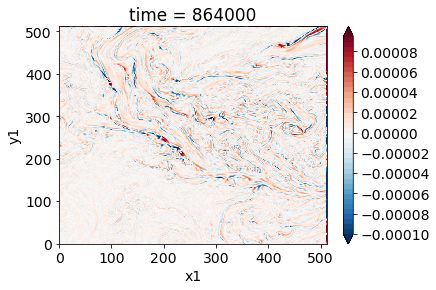

In [128]:
div_filt.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-4)

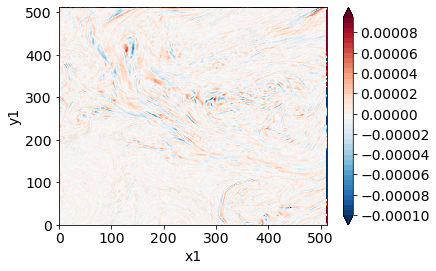

In [129]:
div_eulfilt.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-4)

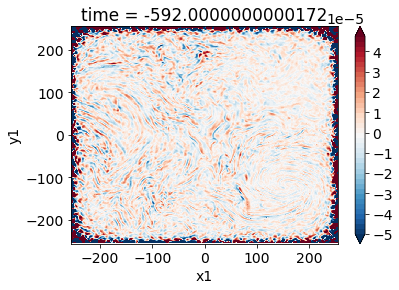

In [116]:
div_wnfilt.isel(time=10).plot(levels=np.arange(-1,1,0.05)*10**-5*5)

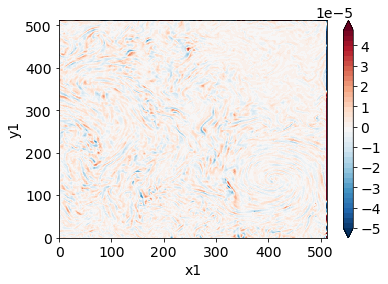

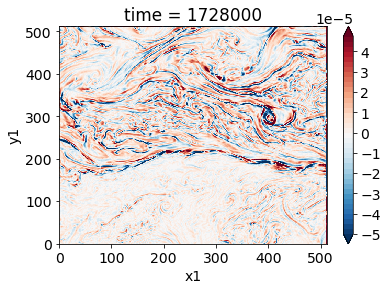

In [29]:
div_unfilt = (tangrid.interp(tangrid.diff(u_unfilt,'X'),'X')+tangrid.interp(tangrid.diff(v_unfilt,'Y'),'Y'))/1000
div_eulfilt = (tangrid.interp(tangrid.diff(u_eul_resampled,'X'),'X')+tangrid.interp(tangrid.diff(v_eul_resampled,'Y'),'Y'))/1000
div_filt = (tangrid.interp(tangrid.diff(u_resampled,'X'),'X')+tangrid.interp(tangrid.diff(v_resampled,'Y'),'Y'))/1000
div_wnfilt = (tangrid.interp(tangrid.diff(u_wnfilt,'X'),'X')+tangrid.interp(tangrid.diff(v_wnfilt,'Y'),'Y'))/1000


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1852: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1848: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


In [134]:
for tt in range(0,70):
    fig=plt.figure(figsize=(14,7))

    plt.subplot(231)
    div_unfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.title('Unfiltered, divergence')

    plt.subplot(232)
    div_eulfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Eulerian, divergence')

    plt.subplot(233)
    div_filt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Lagrangian, divergence')

    plt.subplot(234)
    div_wnfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Freq/wn, divergence')
    
    plt.subplot(235)
    cs = fronto_resampled.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-13,add_colorbar=False)
    plt.ylabel('')
    plt.title('Frontogenesis function')

    plt.tight_layout()

    fig.subplots_adjust(right=0.9,wspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
    fig.colorbar(cs, cax=cbar_ax,extend='both')
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)
    plt.close(fig) 

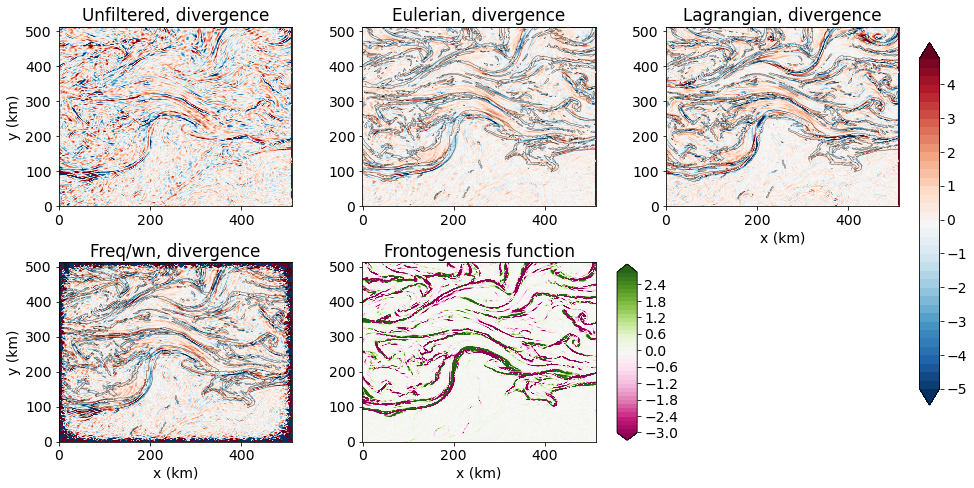

In [38]:
tt=35
fig=plt.figure(figsize=(14,7))

plt.subplot(231)
(div_unfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
plt.title('Unfiltered, divergence')
plt.ylabel('y (km)')
plt.xlabel('')

plt.subplot(232)
(div_eulfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
np.abs(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-1, 0.2],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.xlabel('')
plt.title('Eulerian, divergence')

plt.subplot(233)
(div_filt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
np.abs(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-1, 0.2],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.title('Lagrangian, divergence')
plt.ylabel('')
plt.xlabel('x (km)')

plt.subplot(234)
cs=(div_wnfilt*10**5).drop_vars(['x1','y1']).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
np.abs(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-1, 0.2],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.title('Freq/wn, divergence')
plt.ylabel('y (km)')
plt.xlabel('x (km)')
    
plt.subplot(235)
cs2 = (fronto_resampled*10**14).isel(time=tt).plot(levels=np.arange(-1,1,0.05),add_colorbar=False,cmap='PiYG',rasterized=True)
plt.ylabel('')
plt.xlabel('x (km)')
plt.title('Frontogenesis function')

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')

cbar_ax = fig.add_axes([0.62, 0.11, 0.02, 0.35])
fig.colorbar(cs2, cax=cbar_ax,extend='both')
fig.savefig("divergence_region_A.png",dpi=200)

In [ ]:
tt=35
fig=plt.figure(figsize=(14,7))

plt.subplot(231)
(div_unfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
plt.title('Unfiltered, divergence')
plt.ylabel('y (km)')
plt.xlabel('')

plt.subplot(232)
(div_eulfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
np.abs(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-1, 1],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.xlabel('')
plt.title('Eulerian, divergence')

plt.subplot(233)
(div_filt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
np.abs(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-1, 1],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.title('Lagrangian, divergence')
plt.ylabel('')
plt.xlabel('x (km)')

plt.subplot(234)
cs=(div_wnfilt*10**5).drop_vars(['x1','y1']).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
np.abs(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-1, 1],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.title('Freq/wn, divergence')
plt.ylabel('y (km)')
plt.xlabel('x (km)')
    
plt.subplot(235)
cs2 = (fronto_resampled*10**14).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,cmap='PiYG',rasterized=True)
plt.ylabel('')
plt.xlabel('x (km)')
plt.title('Frontogenesis function')

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')

cbar_ax = fig.add_axes([0.62, 0.11, 0.02, 0.35])
fig.colorbar(cs2, cax=cbar_ax,extend='both')
fig.savefig("divergence_region_B.png",dpi=200)

In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [99]:
div_wnfilt

<xarray.DataArray (time: 70, y1: 512, x1: 512)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           inf, ...,
                   inf,           inf,           inf],
        [          nan,          -inf,  245.13355978, ...,
          146.67173757,  380.95975708,           inf],
        ...,
        [          nan,          -inf,  -64.13544659, ...,
          -15.91344804,  -34.22495237,           inf],
        [          nan,          -inf, -312.09391759, ...,
          -80.08527458, -175.45540384,           inf],
        [          nan,          -inf,          -inf, ...,
                  -inf,          -inf,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,          -inf,          -inf, ...,
                  -inf,          -inf,           nan],
        [          nan,          -inf,  -82.73807617, ...,
          -24.38220722,  -16.35665323,           inf],
...
        [          nan,          -inf,  -45.5773979 , ...,
           -2.90094407,   10.23978611,           inf],
        [          nan,          -inf, -128.99318888, ...,
          -13.49237158,   14.51712323,           inf],
        [          nan,          -inf,          -inf, ...,
                  -inf,          -inf,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,          -inf, ...,
                  -inf,          -inf,          -inf],
        [          nan,           inf, -334.89167055, ...,
          -34.23345736, -147.18012087,          -inf],
        ...,
        [          nan,           inf,   83.08432528, ...,
           -2.13574908,  -15.00308778,          -inf],
        [          nan,           inf,  393.61422613, ...,
           -3.80753345,  -25.29039412,          -inf],
        [          nan,           inf,           inf, ...,
                   inf,           inf,           nan]]])
Coordinates:
  * y1       (y1) float64 -256.0 -255.0 -254.0 -253.0 ... 253.0 254.0 255.0
  * x1       (x1) float64 -256.0 -255.0 -254.0 -253.0 ... 253.0 254.0 255.0
  * time     (time) float64 -832.0 -808.0 -784.0 -760.0 ... 776.0 800.0 824.0

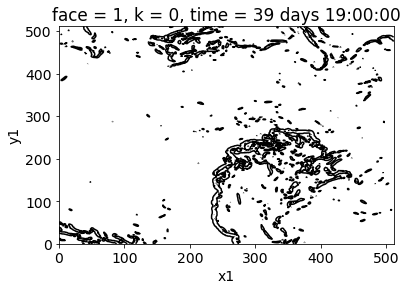

In [86]:
np.abs(fronto_resampled*10**14).isel(time=tt).plot.contour(levels=[-1, 0.1],add_colorbar=False,colors='k')

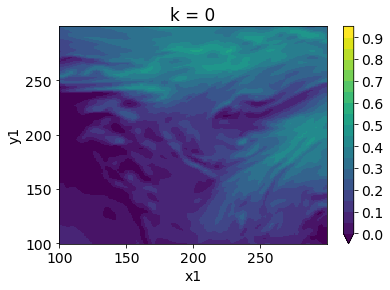

In [124]:
u_eul_resampled.isel(time=2).isel(x1=slice(100,300),y1=slice(100,300)).plot(levels=np.arange(0,1,0.05),cmap='viridis')

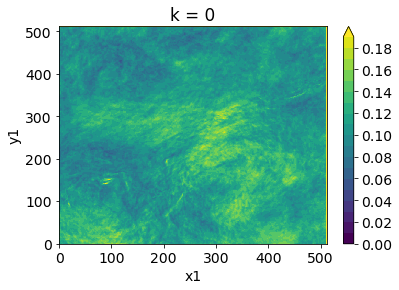

In [13]:
eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())
#eta_resampled = ufunc_resample(ssh_filtered.load())
eta_eul_resampled = ufunc_resample(eta_eul_filtered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


KeyboardInterrupt: 